# Multiclass Perceptron
### Implementing Multiclass Perceptron

Background. Assume we have N training examples {(x1,t1),...,(xN,tN)} where tn can get K discrete values {C1, ..., CK}, i.e. a K-class classification problem. We use 𝑦" to represent the predicted label of 𝑥"

Model. To solve a K-class classification problem, we can learn K weight vectors $W_k$ , each of
which corresponding to one of the classes.

Prediction. In the prediction time, a data point x will be classified as argmaxk wk . x

In [1]:
dtrain <- read.csv("Task1D_train.csv",head=TRUE,sep=",") # training data used to train the model
dtest <- read.csv("Task1D_test.csv",head=TRUE,sep=",") # test data to test the performance of learned model


# Following function is used to separate input variables and class labels
dataAndLabels <- function(data){
    nr = dim(data)[1]
    nc = dim(data)[2]
    x = data[1:nr,1:(nc-1)]
    y = data[1:nr,nc]
    return (list("x" = x, "y" = y))
}
train.data <- dataAndLabels(dtrain)
test.data <- dataAndLabels(dtest)
head(train.data$y)

[1] C1 C1 C1 C1 C1 C1
Levels: C1 C2 C3

### Importing Libraries

In [3]:
## Load required libraries:
options(warn=-1)
library(MASS) # generates multivariate Gaussian sampels
library(ggplot2)
library(reshape2)

## Initialization
set.seed(1234)

### Task II and III: Implementation of Multiclass Perceptron Model:

To solve a K-class classification problem, we can learn K weight vectors $W_k$ , each of which corresponding to one of the classes.

After processing every 5 training data points (also known as a mini-batch), the error of the current model on the test data is recorded.

In [4]:
## Basis function Phi
Phi <- as.matrix(cbind(1, train.data$x)) # add a column of 1s
Phi.test <- as.matrix(cbind(1, test.data$x))
# head(Phi)

In [5]:
# Initialization of parameters
eta <- 0.09 # Learning rate
tau.max <- 100 # Maximum number of iterations
epsilon <- 0.001 # Stoping criterion

tau <- 1 # iteration counter 
terminate <- FALSE # termination status

#### Create weight vectors corresponding to each class in target variable. In present case, there are three classes namely C1, C2, and C3.

In [6]:
# Check the number of classes in the data
print(levels(train.data$y))

# Create a weight vector for classes C1, C2, and C3

W = list() # A list to hold weight vectors for C1, C2, and C3
W$C1 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C1 class's weight vector
W$C1[1,] <- runif(ncol(Phi)) # Random initial values for weight vector
W$C2 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C2 class's weight vector
W$C2[1,] <- runif(ncol(Phi)) # Random initial values for weight vector
W$C3 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C3 class's weight vector
W$C3[1,] <- runif(ncol(Phi)) # Random initial values for weight vector
x = "C1"
W[[x]][1,]
# define an empty data frame to store test error for every mini batch
errors <- data.frame('dataPoints' = numeric(), 'miniBatch' = numeric(), 'testError' = numeric(), 'tau' = numeric())
trainingError <- data.frame()

[1] "C1" "C2" "C3"


[1] 0.1137034 0.6222994 0.6092747 0.6233794 0.8609154

##### Prediction function to make prediction of class label based on the score calculated by using input variable and corresponding weight vector.

In [7]:
# predict_class function predicts the classlable for a given set of input variable
class_predict <- function(Phi, tau){
    C1_score = W$C1[tau,] %*% Phi
    C2_score = W$C2[tau,] %*% Phi
    C3_score = W$C3[tau,] %*% Phi

    prediction = max(C1_score, C2_score, C3_score) # make prediction based on the highest score
    
    # return the lable for the predicted class
    if(prediction == C1_score)
        return ('C1')
    if(prediction == C2_score)
        return ('C2')
    if(prediction == C3_score)
        return ('C3')    
}

##### The following is the main loop where we learn the model paramters using SGD.

In [8]:
dataPoints = 1 # counter to count total number of data points processed for training the model

# Main Loop (Step 2):
while(!terminate){
    # resuffling train data and associated labels:
    train.index <- sample(1:nrow(train.data$x), replace = FALSE)
    train.data$y <- train.data$y[train.index]
    Phi <- Phi[train.index,]
    
    er_train = 0
    for (i in train.index){
        if (tau == tau.max) {break}
        
        # call predict_class function to make a prediction
        predictedClass = class_predict(Phi[i,], tau)
        trueClass = toString(train.data$y[i])

        # Check predicted class against true class and if not a true predictin, update weight for the predicted class and
        # true class
        if (predictedClass != trueClass){
            # update tau counter
            tau <- tau +1
            er_train = er_train + 1 # update training error count
            
            # update the weights. Weight for wrong prediction is decreased and weight for true class is increased to improve
            # selection criteria of model
            W[[trueClass]][tau,] = W[[trueClass]][tau-1,] + (eta * Phi[i,])
            W[[predictedClass]][tau,] = W[[predictedClass]][tau-1,] - (eta * Phi[i,])
            
            # Just update the weight vector for the remaining class with same values
            remainingClass = setdiff(c('C1', 'C2', 'C3'), c(trueClass, predictedClass)) # select the remaining class
            W[[remainingClass]][tau,] = W[[remainingClass]][tau-1,]
        }
        
        if (dataPoints %% 5 == 0){
            error = 0 # to count number of mispredictions

            for (j in 1:nrow(test.data$x)){
                
                prediction = class_predict(Phi.test[j,], tau)
                if (prediction != toString(test.data$y[j])){
                    error = error + 1
                }
            }
            # compute error for the current batch
            error = error / nrow(test.data$x)
            # save the data frame
            errors[nrow(errors)+1, 'dataPoints'] = dataPoints # update row value
            errors[nrow(errors), 'miniBatch'] = dataPoints/5 
            errors[nrow(errors), 'testError'] = error
            errors[nrow(errors), 'tau'] = tau          

        }
        dataPoints = dataPoints + 1
        
    }

    # decrease eta:
    eta = eta * 0.99
    
    # calculate training error
    trainingError[nrow(trainingError)+1, 1] = er_train/ length(train.index)
    
    # check termination conditions
    if (tau >= tau.max){
        terminate <- TRUE
    }
    else if (nrow(trainingError) >= 2 && trainingError[nrow(trainingError),1] < 0.03){
        # check if there is atleast two recorded training errors and training error is less than 3%
        improvement = trainingError[nrow(trainingError),1] - trainingError[nrow(trainingError)-1, 1]
        terminate = improvement < epsilon # terminate if the improvement is minimal
        }
}

W$C1 <- W$C1[1:tau,] # cut the empty part of the matrix (when the loop stops before tau == tau.max)
W$C2 <- W$C2[1:tau,]
W$C3 <- W$C3[1:tau,]

##### Let's see the errors

In [9]:
head(errors)

dataPoints,miniBatch,testError,tau
<dbl>,<dbl>,<dbl>,<dbl>
5,1,0.6666667,4
10,2,0.6666667,8
15,3,0.6666667,10
20,4,0.3600000,13
25,5,0.6666667,16
30,6,0.4000000,20


### Visualization
Plot: "Number of Mini-batches vs. Test Error"

[1] 0.04


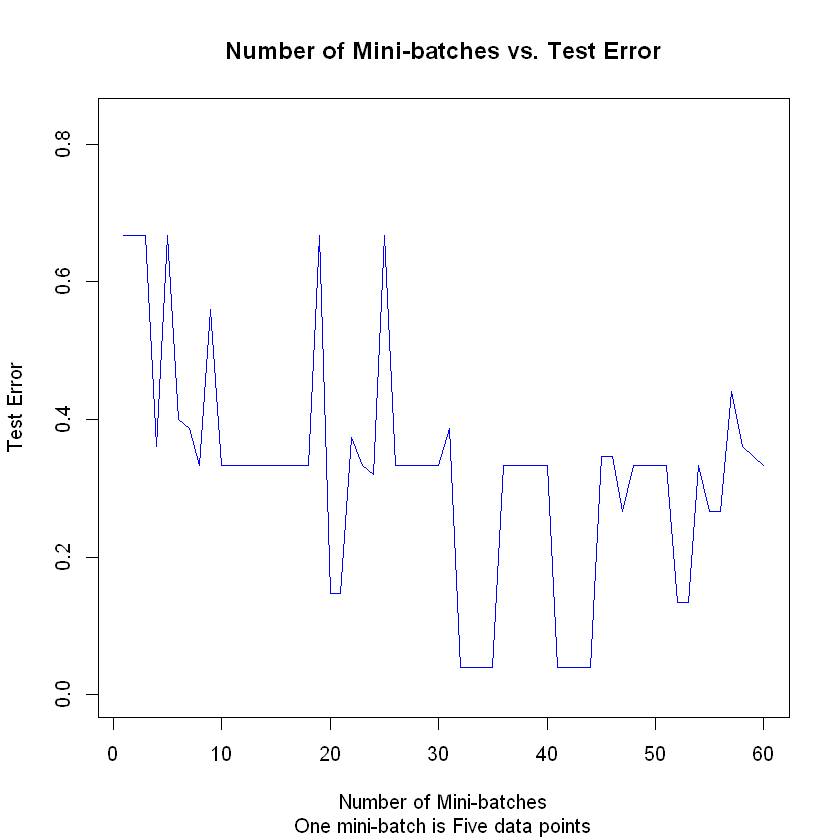

In [10]:
# minimum error
print(min(errors[ ,'testError']))

## ## plot number of mini batches vs test error
plot(x = errors[ ,'miniBatch'], y =errors[ ,'testError'], ylim = c(0,max(errors[ ,'testError']*1.25)), type = 'l', 
     col = 'blue', main = "Number of Mini-batches vs. Test Error", xlab = "Number of Mini-batches", ylab = "Test Error",
     sub = "One mini-batch is Five data points")
errors.m <- melt(as.data.frame(errors), id='miniBatch')

# tau vs test error
# plot(x = errors[ ,'tau'], y =errors[ ,'testError']*100, ylim = c(0,max(errors[ ,'testError']*1.25*100)), type = 'l', 
#      col = 'blue', main = "Number of Mini-batches vs. Test Error", xlab = "Number of Mini-batches", ylab = "Test Error",
#      sub = "One mini-batch is Five data points")

### Observations

1. Test error for the model decreases with increase in the number of mini-batches but at same time error fluctuates highly.

2. From mini-batch 30 to 45 the error rate is minimum (0.01) for the model.


### K(K−1)/2 classifier and One-versus-one approach to solve the multi-class classification problem

The idea is to build K(K−1)/2 classifiers for each possible pair of classes where K is the number of classes. Each point is then classified according to a majority vote among the discriminant functions.